In [1]:
import os
import sys
import matplotlib.pyplot as plt
from pyproj import CRS
from pyresample import geometry
import numpy as np
import xarray as xr
from PIL import Image
import copy

from skimage import data, img_as_float
from skimage import exposure

import satpy
import satpy.resample

from satpy.composites import SingleBandCompositor, GenericCompositor
#from trollimage.image import Image
from satpy.writers import to_image
from trollimage.colormap import greys, gnbu, bugn, greens, orrd, rdylgn, pubugn, ylgn, brbg
#from trollimage.image import Image
from pycoast import ContourWriterAGG

from scipy.signal import find_peaks

import glob
from satpy import Scene

from pyresample.geometry import SwathDefinition

sys.path.insert(0, '/home/cameron/Projects/hypso-package')

# Import Satellite Object
from hypso import Hypso1

In [2]:
if True:
    dir_path = '/home/cameron/Dokumenter/Data/frohavet'
    nc_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-l1a.nc')
    points_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-bin3.points')
    cloud_mask_quantile = 0.6
    sentinel_3_dir = "/home/cameron/Dokumenter/Frohavet_Sentinel_3/S3B_OL_2_WFR____20240506T102040_20240506T102340_20240506T122602_0179_092_336_1800_MAR_O_NR_003.SEN3"

if False:
    dir_path = '/home/cameron/Dokumenter/Data/erie'
    nc_file = os.path.join(dir_path, 'erie_2022-07-20_1539Z-l1a.nc')
    points_file = os.path.join(dir_path, 'erie_2022-07-20_1539Z-bin3.points')

if False:
    dir_path = '/home/cameron/Dokumenter/Data/frohavet'
    nc_file = os.path.join(dir_path, 'frohavet_2024-04-26_1049Z-l1a.nc')
    points_file = os.path.join(dir_path, 'frohavet_2024-04-26_1049Z-bin3.points')

if False:
    dir_path = "/home/cameron/Dokumenter/Data/roervik/"
    nc_file = os.path.join(dir_path, 'roervik_2024-05-05_1039Z-l1a.nc')
    points_file = os.path.join(dir_path, 'roervik_2024-05-05_1039Z-bin3.points')
    cloud_mask_quantile = 0.85
    sentinel_3_dir = "/home/cameron/Dokumenter/Frohavet_Sentinel_3/S3B_OL_2_WRR____20240505T103843_20240505T112305_20240506T142550_2662_092_322______MAR_O_NT_003.SEN3"

if False:
    dir_path = "/home/cameron/Dokumenter/Data/frohavet/"
    nc_file = os.path.join(dir_path, 'frohavet_2024-04-26_1049Z-l1a.nc')
    points_file = os.path.join(dir_path, 'frohavet_2024-04-26_1049Z-bin3.points')
    cloud_mask_quantile = 0.5
    sentinel_3_dir = "/home/cameron/Dokumenter/Frohavet_Sentinel_3/S3B_OL_2_WRR____20240426T093209_20240426T101628_20240427T120354_2659_092_193______MAR_O_NT_003.SEN3"


In [3]:
satobj = Hypso1(hypso_path=nc_file, points_path=points_file, verbose=True)

#satobj._run_calibration(destriping_corr=False)
satobj.generate_l1b_cube(compute_destriping_matrix=True)
#satobj.generate_land_mask(land_mask='global')
#satobj.generate_land_mask(land_mask='ndwi')

[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running georeferencing...
No image mode provided. Detected image mode: bin3
[INFO] Using UTM map: WGS 84 / UTM zone 32N EPSG: 32632
[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running smile correction...
[INFO] Running destriping correction...


In [ ]:
satobj.add_product(product_name=)

In [5]:
s = satobj.get_products_satpy_scene()

In [6]:
s['latitude']

<xarray.DataArray (y: 598, x: 1092)>
array([[65.5340918 , 65.53395482, 65.53381781, ..., 65.36610637,
        65.3659348 , 65.3657632 ],
       [65.52914767, 65.52901068, 65.52887366, ..., 65.36115259,
        65.36098102, 65.36080941],
       [65.52420333, 65.52406634, 65.52392931, ..., 65.35619862,
        65.35602704, 65.35585542],
       ...,
       [62.55753585, 62.55739361, 62.55725133, ..., 62.38381524,
        62.38363841, 62.38346154],
       [62.55247456, 62.55233231, 62.55219002, ..., 62.37874431,
        62.37856747, 62.37839059],
       [62.54741307, 62.54727081, 62.54712852, ..., 62.37367318,
        62.37349633, 62.37331945]])
Dimensions without coordinates: y, x
Attributes:
    name:                 latitude
    _satpy_id:            DataID(name='latitude')
    file_type:            None
    resolution:           592.8625951680069
    standard_name:        latitude
    units:                degrees_north
    start_time:           2024-05-06 10:17:00
    end_time:             2024-05-06 10:17:00
    modifiers:            ()
    ancillary_variables:  []

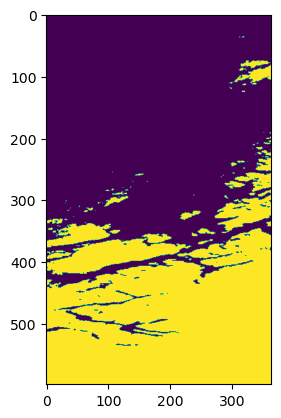

In [4]:
satobj._run_quantile_threshold_cloud_mask(quantile=cloud_mask_quantile)
plt.imshow(satobj.cloud_masks['quantile_threshold'][:,::3])

In [20]:
#satobj.calibration_has_run = False
#satobj.chlorophyll_estimation_has_run = False
satobj.generate_chlorophyll_estimates(product='band_ratio')

if False:
    model = "/home/cameron/Dokumenter/Chlorophyll_NN_Models/model_6sv1_aqua_tuned.joblib"
    satobj.generate_chlorophyll_estimates(product="6sv1_aqua", model=model)
    satobj.get_chlorophyll_estimates(product="6sv1_aqua")

[INFO] Running band ratio chlorophyll estimation...
[INFO] Calibration has already been run. Skipping.


In [21]:
l1a_scene = satobj.get_l1a_satpy_scene()
l1b_scene = satobj.get_l1b_satpy_scene()
chl_scene = satobj.get_chlorophyll_satpy_scene()

print(chl_scene._datasets.keys())

[DataID(name='chl_band_ratio'), DataID(name='latitude'), DataID(name='longitude')]


In [22]:
from pyproj import Transformer
from pyproj import Proj

area_id = satobj.capture_region
proj_id = 'roi'
description = 'roi'

bbox = satobj.get_bbox()
lon_0 = (bbox[2] - bbox[0])/2 + bbox[0]
lat_ts = (bbox[3] - bbox[1])/2 + bbox[1]

p = Proj(proj="stere", ellps="bessel", lat_0=90.0, lon_0=lon_0, lat_ts=lat_ts)
#Transformer.from_proj
#p(12.06, 65.26)
#p(-100000, -2950000, inverse=True)

projection = {"proj": "stere", 
              "ellps": "bessel", 
              "lat_0": 90.0, 
              "lon_0": lon_0, 
              "lat_ts": lat_ts, 
              "units": "m"}

#projection = CRS.from_proj4("+proj=latlon")
#projection = p.to_proj4()

swath_def = SwathDefinition(lons=satobj.longitudes, lats=satobj.latitudes)
projection = swath_def.compute_bb_proj_params(proj_dict=projection)

lower_left_x, lower_left_y = p(bbox[0], bbox[1])
upper_right_x, upper_right_y = p(bbox[2], bbox[3])
area_extent = (lower_left_x, lower_left_y, upper_right_x, upper_right_y)

res = 300 #meters

width = (area_extent[2] - area_extent[0]) / res
height = (area_extent[3] - area_extent[1]) / res

area_def = geometry.AreaDefinition(area_id, proj_id, description, projection,  width, height, area_extent)

#from pyresample import load_area
#area_def = load_area("./frohavet.yaml")

In [23]:
resampled_chl_scene = None
resampled_l1a_scene = None
size = None

resampled_l1a_scene = l1b_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)
#resampled_l1b_scene = l1b_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)
resampled_chl_scene = chl_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [24]:
size = (area_def.shape[1], area_def.shape[0])

# Base image
base_img = Image.new(mode="RGBA", size=size, color=(173, 216, 230))
cw = ContourWriterAGG('/home/cameron/Dokumenter/Pycoast')
cw.add_coastlines(base_img, area_def, resolution='f', outline='black', fill='gray')

# Overlay image
overlay_img = Image.new(mode="RGBA", size=size)
cw = ContourWriterAGG('/home/cameron/Dokumenter/Pycoast')
cw.add_coastlines(overlay_img, area_def, resolution='f', outline='black', level=4)
cw.add_rivers(overlay_img, area_def, level=10, outline='blue', resolution='f')
#cw.add_borders(overlay_img, area_def, outline=(255, 0, 0))


boundary_lats, boundary_lons = swath_def.get_boundary_lonlats()

side1 = tuple((lat, lon) for lat, lon in zip(boundary_lats.side1, boundary_lons.side1))
side2 = tuple((lat, lon) for lat, lon in zip(boundary_lats.side2, boundary_lons.side2))
side3 = tuple((lat, lon) for lat, lon in zip(boundary_lats.side3, boundary_lons.side3))
side4 = tuple((lat, lon) for lat, lon in zip(boundary_lats.side4, boundary_lons.side4))

polygon_coords = side1 + side2 + side3 + side4

#from shapely import Polygon
#polygon = Polygon(polygon_coords)

# Overlay image
boundary_img = Image.new(mode="RGBA", size=size)
cw = ContourWriterAGG('/home/cameron/Dokumenter/Pycoast')
cw.add_polygon(boundary_img, area_def, polygon_coords, outline='red', width=3)

In [25]:
# RGB Hypso image
compositor = GenericCompositor("rgb")

#R:630nm, G:550nm, B:480nm
# Red, Green, Blue, Alpha
red_wl = 630
green_wl = 550
blue_wl = 480

red_idx = satobj.get_closest_wavelength_index(red_wl)
green_idx = satobj.get_closest_wavelength_index(green_wl)
blue_idx = satobj.get_closest_wavelength_index(blue_wl)

red_band = 'band_' + str(red_idx)
green_band = 'band_' + str(green_idx)
blue_band = 'band_' + str(blue_idx)

composite = compositor([resampled_l1a_scene[red_band], 
                        resampled_l1a_scene[green_band], 
                        resampled_l1a_scene[blue_band], 
                        resampled_l1a_scene['band_5']]) 

rgb_img = to_image(composite) 
rgb_img.stretch_linear()
rgb_img.gamma(2)

rgb_xr_image = rgb_img

rgb_img = rgb_img.pil_image()

rgb_img.save('./' + satobj.capture_name + '_rgb_only.png')

/home/cameron/miniforge3/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [26]:
#plotting_cm = ylgn
plotting_cm = bugn

In [27]:
chl_product = 'chl_band_ratio'
#chl_product = 'chl_6sv1_aqua'
#chl_min = 0
#chl_max = np.nanmax(resampled_chl_scene[chl_product])

#chl_product = 'chl_band_ratio'
#chl_min = 1.9
#chl_max = 2.2

#chl_product = 'chl_6sv1_aqua'
#chl_min = 0
#chl_max = 2

resampled_chl_scene['chl_plotted'] = copy.deepcopy(resampled_chl_scene[chl_product])

values = None
del values
values = None

values = copy.deepcopy(resampled_chl_scene[chl_product].to_numpy())
#values[values<chl_min] = np.nan
#values[values>chl_max] = np.nan
#values = np.log10(values)
#values = 10**values

# Contrast stretching
if True:
    p2, p98 = np.nanpercentile(values, (2, 98))
    values = exposure.rescale_intensity(values, in_range=(p2, p98))

# Equalization
if False:
    mask = np.isnan(values)
    values = exposure.equalize_hist(values, mask=~mask)

# Adaptive Equalization
if False:

    # Scale between -1 and 1
    values = 2 * (values - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values)) - 1

    # Create a mask for NaN values
    nan_mask = np.isnan(values)

    # Fill NaN values with a neutral value (e.g., the mean of the non-NaN elements)
    values_no_nan = np.copy(values)
    mean_value = np.nanmean(values_no_nan)
    values_no_nan[nan_mask] = mean_value

    # Apply adaptive histogram equalization
    values_eq = exposure.equalize_adapthist(values_no_nan, clip_limit=0.01)

    # Reapply the NaN mask to the equalized image
    values_eq[nan_mask] = np.nan

    values = values_eq

if False:
    from skimage.filters.rank import mean
    from skimage.morphology import disk

    # Create a mask for NaN values
    nan_mask = np.isnan(values)

    # Fill NaN values with a neutral value (e.g., the mean of the non-NaN elements)
    values_no_nan = np.copy(values)
    mean_value = np.nanmean(values_no_nan)
    values_no_nan[nan_mask] = mean_value
    values_smoothed = mean(values_no_nan, disk(7))
    values_smoothed = values_smoothed.astype('float')
    values_smoothed[nan_mask] = np.nan
    values = values_smoothed


values = (values - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values)) 
#values = 2 * (values - np.nanmin(values)) / (np.nanmax(values) - np.nanmin(values)) - 1

resampled_chl_scene['chl_plotted'].values = values

#chl_min = 0.2
#chl_max = 1.2

#chl_min = 0.1
#chl_max = 1.1

chl_min = 0
chl_max = 1.1

chl_ds = resampled_chl_scene['chl_plotted']


compositor = SingleBandCompositor('chl')
composite = compositor([chl_ds])
chl_img = to_image(composite) 
chl_cm = plotting_cm.set_range(chl_min,chl_max,inplace=False)
chl_cm.reverse()
chl_img.colorize(chl_cm)
chl_img = chl_img.pil_image()


chl_img_2 = to_image(composite) 
chl_cm = plotting_cm.set_range(chl_min,chl_max,inplace=False)
chl_cm.reverse()
chl_img_2.colorize(chl_cm)
chl_img_2 = chl_img_2.pil_image()

combined_img = Image.alpha_composite(base_img, rgb_img)
combined_img = Image.alpha_composite(base_img, chl_img)
combined_img = Image.alpha_composite(combined_img, boundary_img)
combined_img = Image.alpha_composite(combined_img, overlay_img)
combined_img.save('./' + satobj.capture_name + '_hypso_chl.png')


from pydecorate import DecoratorAGG

combined_img = Image.alpha_composite(base_img, rgb_img)
combined_img = Image.alpha_composite(combined_img, boundary_img)
combined_img = Image.alpha_composite(combined_img, overlay_img)



if False:
    chl_cm = plotting_cm.set_range(chl_min,chl_max,inplace=False)
    dc = DecoratorAGG(combined_img)
    dc.write_vertically()
    dc.align_right()
    dc.align_bottom()

    #dc.add_text("HYPSO-1 HSI\n" + str(satobj.capture_name), height=180)
    #dc.add_logo("../assets/HYPSO_logo.png")

    dc.add_scale(chl_cm, extend=False, max_val=1, height = 512, margins=[10,10])


combined_img.save('./' + satobj.capture_name + '_hypso_rgb.png')

combined_img = Image.alpha_composite(base_img, rgb_img)
combined_img = Image.alpha_composite(combined_img, chl_img_2)
combined_img = Image.alpha_composite(combined_img, boundary_img)
combined_img = Image.alpha_composite(combined_img, overlay_img)
combined_img.save('./' + satobj.capture_name + '_hypso_combined.png')

/home/cameron/miniforge3/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/cameron/miniforge3/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/cameron/miniforge3/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [28]:

filenames = []
filenames = filenames + glob.glob(sentinel_3_dir + '/geo_coordinates.nc')
filenames = filenames + glob.glob(sentinel_3_dir + '/chl_nn.nc')
filenames = filenames + glob.glob(sentinel_3_dir + '/tsm_nn.nc')

s3_scene = Scene(filenames=filenames, reader='olci_l2')

s3_scene.load(['chl_nn', 'tsm_nn', 'latitude', 'longitude'])

s3_scene['chl_nn'].data = 10**s3_scene['chl_nn'].data

resampled_s3_scene = s3_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)

/home/cameron/miniforge3/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [29]:
s3_min = 0
s3_max = 10
#chl_max = np.nanmax(chl_scene[chl_product].to_numpy())

compositor = SingleBandCompositor('s3_chl')
composite = compositor([resampled_s3_scene['chl_nn']])
s3_img = to_image(composite) 
s3_cm = plotting_cm.set_range(min_val=s3_min, max_val=s3_max, inplace=True)
#s3_cm.reverse()
s3_img.colorize(s3_cm)
s3_img = s3_img.pil_image()

combined_s3_img = Image.alpha_composite(base_img, s3_img)
combined_s3_img = Image.alpha_composite(combined_s3_img, boundary_img)
combined_s3_img = Image.alpha_composite(combined_s3_img, overlay_img)

combined_s3_img.save('./' + satobj.capture_name + '_sentinel3_chl.png')

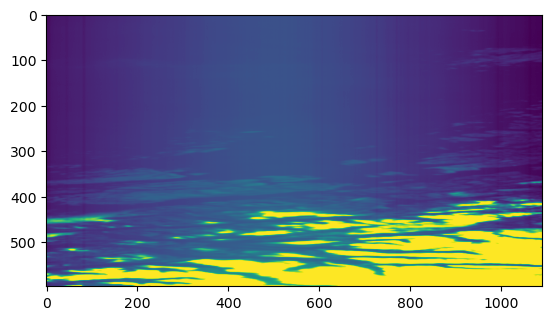

In [11]:
plt.imshow(satobj.l1a_cube[:,:,20])

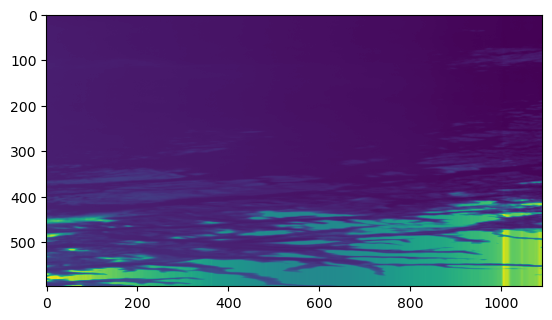

In [12]:
plt.imshow(satobj.l1b_cube[:,:,20])

In [17]:
c = np.zeros((satobj.l1b_cube.shape[0],satobj.l1b_cube.shape[1]))

c[:,:] = satobj.destriping_coeffs[:,20]


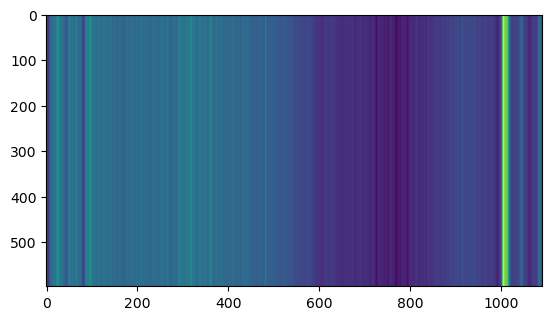

In [18]:
plt.imshow(c)

In [12]:
datacube = satobj.l1a_cube.to_numpy()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

height, width, bands = datacube.shape
reshaped_data = datacube.reshape(-1, bands)

# Apply PCA
pca = PCA(n_components=5)
pca_data = pca.fit_transform(reshaped_data)

# Reconstruct the data without stripe-related components
#reconstructed_data = pca.inverse_transform(pca_data)
#destriped_cube = reconstructed_data.reshape(height, width, bands)


In [17]:
pca_comps = pca_data.reshape(height, width, 5)

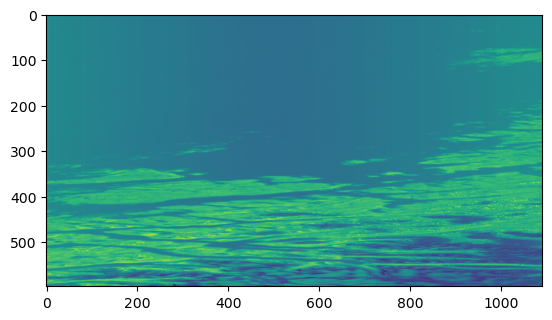

In [22]:
plt.imshow(pca_comps[:,:,2])

In [24]:
pca_comps[:,:,2].attrs

AttributeError: 'numpy.ndarray' object has no attribute 'attrs'

In [4]:
class NumpyArrayDict(dict):
    def __setitem__(self, key, value):
        """Override the method for setting a dictionary item."""
        if not isinstance(value, np.ndarray):
            raise TypeError(f"Value must be of type np.ndarray, but got {type(value).__name__}")
        super().__setitem__(key, value)

    def update(self, *args, **kwargs):
        """Override the update method to check all added values."""
        if args:
            other = dict(args[0]) if len(args) == 1 else dict(args)
            for key, value in other.items():
                self[key] = value
        for key, value in kwargs.items():
            self[key] = value

In [5]:
n = NumpyArrayDict()

In [9]:
n['hello'] = np.zeros(2)

In [10]:
n['hello']

array([0., 0.])

In [12]:
n.keys()

dict_keys(['hello'])

In [13]:
type(n)

__main__.NumpyArrayDict

In [ ]:
class DataArrayDict(dict):
    def __setitem__(self, key, value):
        """Override the method for setting a dictionary item."""
        # Ensure key is lowercased
        key = key.lower()

        # Convert the value to an xarray.DataArray
        if isinstance(value, np.ndarray):
            value = self.convert_to_xarray(value)
        elif not isinstance(value, xr.DataArray):
            raise TypeError("Value must be a numpy ndarray or xarray DataArray.")

        # Store the xarray.DataArray in the dictionary
        super().__setitem__(key, value)

    def convert_to_xarray(self, data):
        """Convert a numpy ndarray to an xarray DataArray with specified dimensions."""
        if data.ndim == 2:
            dims = ('y', 'x')
        elif data.ndim == 3:
            dims = ('y', 'x', 'bands')
        else:
            raise ValueError("Data must be 2D or 3D.")

        return xr.DataArray(data, dims=dims)

    def __getitem__(self, key):
        """Override to ensure lowercase key access."""
        return super().__getitem__(key.lower())

    def get(self, key, default=None):
        """Override to ensure lowercase key access."""
        return super().get(key.lower(), default)